In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.stats import skew, kurtosis, anderson
from scipy.stats import kstest, norm
import scipy.stats as stats
import math
from statsmodels.graphics.tsaplots import plot_acf
from data_analysis_utils import wpe_row


In [28]:
df_test= pd.read_parquet('data/data_storage/ecg_parquets/test_ecg.parquet')
df_train = pd.read_parquet('data/data_storage/ecg_parquets/train_ecg.parquet')
df_val = pd.read_parquet('data/data_storage/ecg_parquets/val_ecg.parquet')

df = pd.concat([df_train, df_val, df_test], axis=0)

In [30]:
df

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,complexity
0,-0.105,-0.105,-0.105,-0.045,-0.025,-0.145,-0.075,-0.145,-0.115,-0.065,...,-0.045,0.025,-0.095,-0.155,-0.125,-0.105,-0.025,-0.175,-0.145,0.727067
1,1.865,-0.055,-0.075,-0.105,-0.205,-0.155,-0.035,-0.045,-0.005,-0.015,...,-0.055,-0.065,-0.045,-0.045,-0.045,-0.045,-0.035,-0.035,0.055,0.774681
2,-0.025,-0.215,-0.635,-0.255,-0.265,-0.125,0.275,0.025,-0.205,-0.185,...,-0.135,0.235,0.275,-0.145,-0.145,-0.145,-0.145,-0.155,-0.105,0.919017
3,-0.195,-0.205,-0.175,-0.155,-0.185,0.015,-0.105,-0.035,0.075,0.295,...,-0.175,-0.145,-0.085,-0.155,1.195,-0.045,0.015,0.115,0.345,0.918043
4,-0.205,-0.115,-0.145,2.705,-0.255,-0.235,-0.125,0.225,0.075,-0.135,...,-0.125,-0.155,0.245,-0.265,-0.245,-0.125,0.225,-0.035,-0.195,0.681726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,-0.265,-0.145,0.065,0.095,-0.145,-0.255,-0.075,-0.005,-0.095,0.475,...,-0.175,-0.165,-0.125,-0.165,-0.205,-0.045,-0.175,-0.135,0.065,0.863141
6246,-0.195,2.295,-0.045,0.065,0.255,0.655,0.125,-0.255,-0.245,-0.215,...,0.315,-0.215,-0.225,-0.195,-0.195,-0.215,-0.205,-0.185,-0.165,0.890553
6247,-0.305,-0.185,-0.095,0.195,0.095,-0.195,-0.145,-0.175,-0.065,-0.195,...,-0.075,0.015,-0.185,0.135,-0.045,-0.125,0.025,0.285,-0.055,0.953977
6248,-0.035,-0.175,-0.145,-0.105,-0.135,-0.065,-0.155,-0.085,-0.215,-0.075,...,-0.145,-0.125,-0.205,-0.095,-0.105,-0.135,-0.035,0.165,0.275,0.899055



###  Dataset Structure

Our dataset has shape (62,500, 80):
- Each row represents a separate synthetic time series sample.
- Each column corresponds to a time step.


We start our analysis by looking at the duplicates and null values and by checking if all the columns have same values.

In [11]:
print(df.duplicated().sum())

105


Out of 62,500 measurements, only 105 are duplicates, which is just 0.17% of the data. These duplicates are likely due to natural patterns in heartbeat data, where similar or identical time series can occur, especially in short, stable segments. The small proportion of duplicates does not significantly impact the dataset size or variability. Therefore, keeping these duplicates is justified and does not affect the quality of the analysis.

In [12]:
duplicates = df[df.duplicated(keep=False)]
duplicates = duplicates.sort_values(by=duplicates.columns[0])
duplicates

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
2888,-1.975,0.095,0.245,0.495,0.415,-0.275,-0.345,-0.255,-0.245,-0.275,...,0.415,0.645,-0.025,-0.305,-0.235,-0.165,-0.215,-0.225,-0.215,-0.215
2038,-1.975,0.095,0.245,0.495,0.415,-0.275,-0.345,-0.255,-0.245,-0.275,...,0.415,0.645,-0.025,-0.305,-0.235,-0.165,-0.215,-0.225,-0.215,-0.215
3182,-1.135,-1.005,-0.945,-0.845,-0.865,-0.825,-0.825,-0.035,-0.825,-0.695,...,-1.155,-1.225,-1.185,-1.105,-1.235,-1.045,-1.225,-1.215,-1.115,-1.125
583,-1.135,-1.005,-0.945,-0.845,-0.865,-0.825,-0.825,-0.035,-0.825,-0.695,...,-1.155,-1.225,-1.185,-1.105,-1.235,-1.045,-1.225,-1.215,-1.115,-1.125
69,-0.495,-0.165,-0.175,-0.225,-0.275,-0.115,-0.125,-0.105,-0.095,-0.095,...,-0.015,-0.015,-0.025,-0.005,0.065,-0.065,-0.025,1.645,-0.075,-0.085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49609,0.405,-0.145,-0.185,-0.165,-0.165,-0.175,-0.175,-0.165,-0.025,-0.185,...,-0.185,-0.185,-0.195,-0.185,-0.075,-0.205,-0.075,-0.725,-0.095,-0.015
3624,0.595,0.625,-0.095,-0.155,-0.035,0.035,0.015,0.025,0.025,0.075,...,-0.115,0.095,0.275,-0.325,-0.385,-0.325,-0.285,-0.285,-0.265,-0.225
3675,0.595,0.625,-0.095,-0.155,-0.035,0.035,0.015,0.025,0.025,0.075,...,-0.115,0.095,0.275,-0.325,-0.385,-0.325,-0.285,-0.285,-0.265,-0.225
1298,0.685,0.035,-0.245,-0.225,-0.165,-0.205,-0.215,-0.205,-0.185,-0.045,...,-0.205,-0.225,-0.255,-0.235,-0.225,-0.195,-0.175,-0.135,-0.135,-0.185


In [13]:
print(df.isnull().sum().unique())

[0]


In [14]:
print(df.dtypes.unique())

[dtype('float64')]


## Descriptive Statistics
This section summarizes the statistical properties of the time series values across the dataset.

We start by visualizing the global descriptive statistics.

In [15]:
print("Shape of dataset:", df.shape)

global_mean = df.values.mean()
global_std = df.values.std()
global_min = df.values.min()
global_max = df.values.max()
global_skew = skew(df.values.flatten())
global_kurtosis = kurtosis(df.values.flatten())

print(f"Global mean: {global_mean:.4f}")
print(f"Global std: {global_std:.4f}")
print(f"Min value: {global_min:.4f}")
print(f"Max value: {global_max:.4f}")
print(f"Skewness: {global_skew:.4f}")
print(f"Kurtosis: {global_kurtosis:.4f}")

Shape of dataset: (62500, 80)


Global mean: -0.0492
Global std: 0.3989
Min value: -5.1150
Max value: 5.0950
Skewness: 3.4947
Kurtosis: 28.7009


Then we go on visulaizing the descriptive statistics of each column separatelly. 

This reveals whether there are trends, drifts or non-stationarity over time and helps us to identify changes in variance or mean throughout the sequence.


In [16]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
count,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,...,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000,62500.000000
mean,-0.046436,-0.049985,-0.047672,-0.048253,-0.049644,-0.048070,-0.050066,-0.049071,-0.050846,-0.047214,...,-0.047771,-0.048491,-0.049207,-0.046906,-0.045815,-0.047930,-0.049287,-0.049681,-0.046554,-0.047514
std,0.402438,0.399063,0.404318,0.403956,0.399309,0.396775,0.396316,0.398311,0.400625,0.402729,...,0.399464,0.398001,0.398230,0.400218,0.405049,0.403714,0.397873,0.394071,0.401898,0.394527
min,-5.115000,-5.115000,-5.115000,-5.115000,-5.115000,-5.115000,-5.115000,-5.115000,-5.055000,-4.995000,...,-4.415000,-4.395000,-4.395000,-4.395000,-4.415000,-4.425000,-4.435000,-4.435000,-4.435000,-4.595000
25%,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,...,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000,-0.185000
50%,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,...,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000,-0.115000
75%,-0.015000,-0.025000,-0.025000,-0.015000,-0.025000,-0.015000,-0.015000,-0.015000,-0.025000,-0.025000,...,-0.025000,-0.025000,-0.025000,-0.025000,-0.015000,-0.025000,-0.015000,-0.015000,-0.015000,-0.015000
max,4.835000,4.715000,4.735000,4.445000,4.455000,4.505000,4.555000,4.585000,4.625000,4.655000,...,4.955000,4.975000,4.985000,4.975000,4.995000,5.015000,5.015000,5.015000,5.065000,4.945000


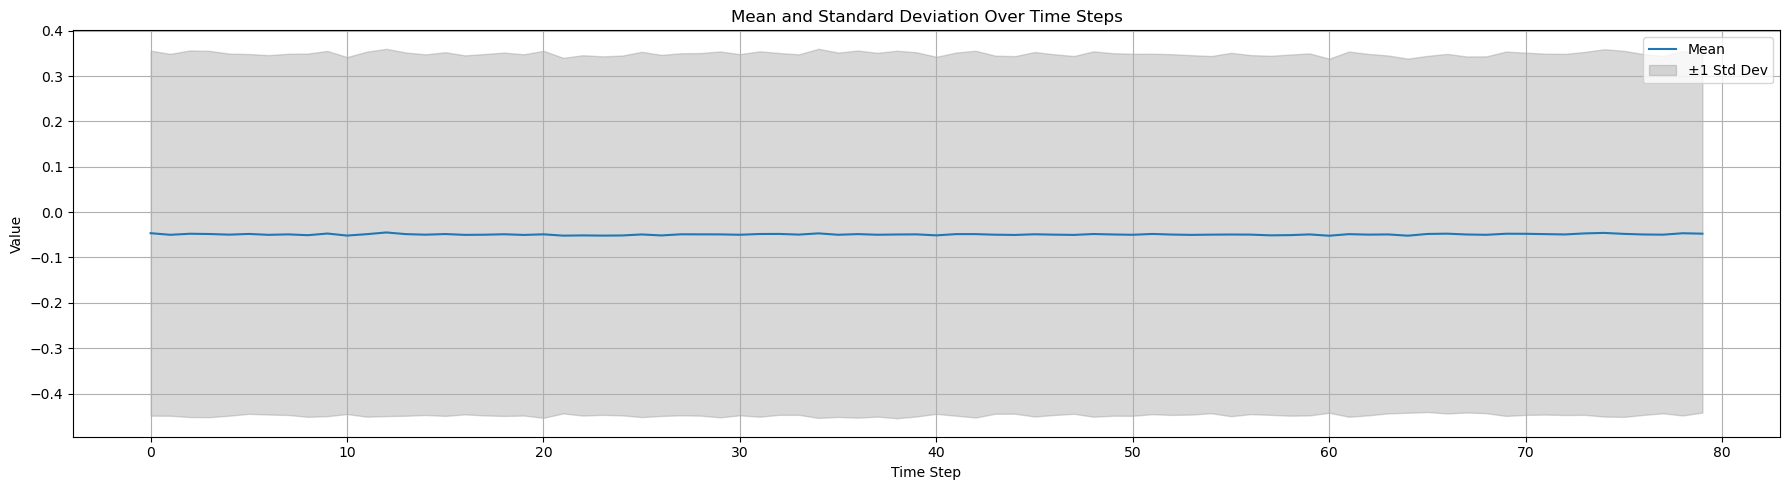

In [17]:
time_means = df.mean(axis=0)
time_stds = df.std(axis=0)
time_mins = df.min(axis=0)
time_maxs = df.max(axis=0)


plt.figure(figsize=(18, 5))
plt.plot(time_means, label='Mean')
plt.fill_between(range(len(time_means)),
                 time_means - time_stds,
                 time_means + time_stds,
                 color='gray', alpha=0.3, label='±1 Std Dev')
plt.title("Mean and Standard Deviation Over Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We notice that mean and standard deviation are pratically the same. In particular, we see that the means of the columns are all around 0, which makes sense in our case since we are dealing with heartbeat data. Heartbeat measurements typically oscillate around a baseline, and the data is often centered to remove any baseline offset. This allows us to focus on the variations and patterns in the heart rhythm itself, making a mean close to 0 a natural outcome.

## Complexity 

We now use a function we previously created to calculate the complexity of the dataset.

In [29]:
df['complexity'] = df.apply(wpe_row, axis=1)

In [31]:
print(f'the complexity of the first row is {df["complexity"].mean()}')

the complexity of the first row is 0.836332217150065


## Visualize Time Series Structure
Let's have a look at how these time series look like. To do so we take three sample time series and we plot them.

In [18]:
colors = ['pink', 'lightblue', 'lightgreen']  
sample_indices = [30000,43000,50000]  

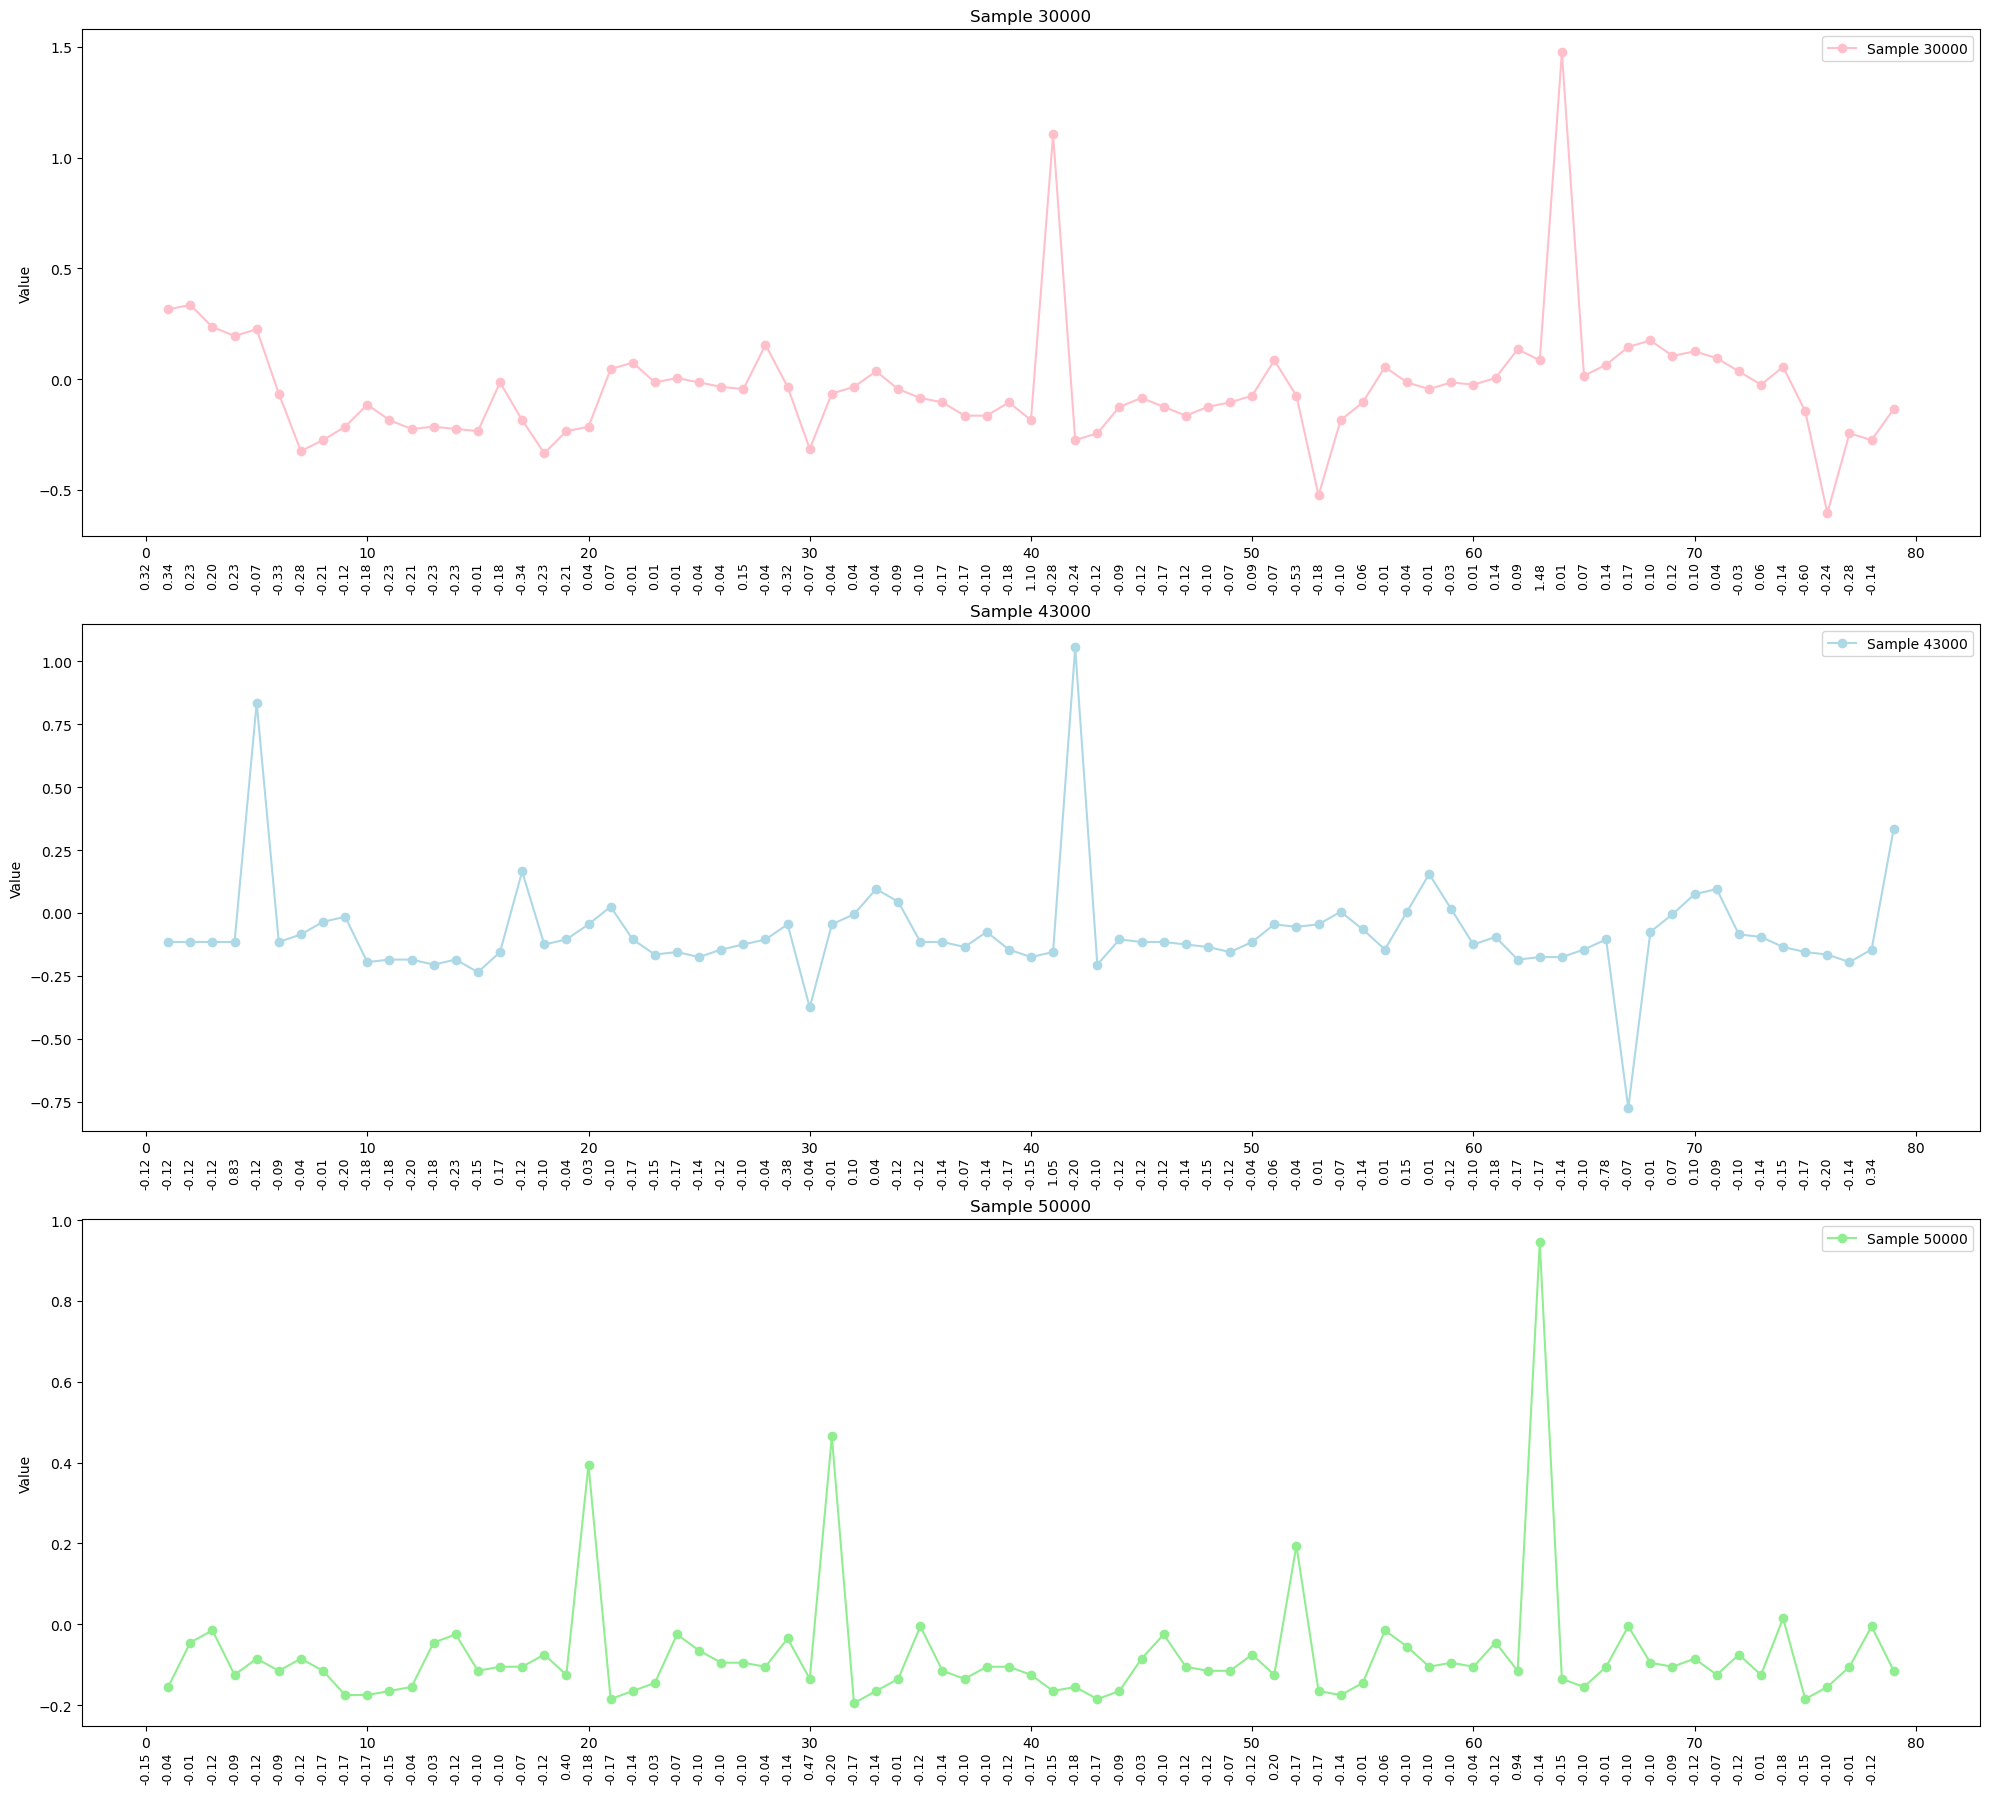

In [19]:
fig, axes = plt.subplots(len(sample_indices), 1, figsize=(20, 6 * len(sample_indices)))

for i, idx in enumerate(sample_indices):
    axes[i].plot(df.columns[1:], df.iloc[idx, 1:], label=f'Sample {idx}', color=colors[i], marker='o')
    axes[i].set_title(f'Sample {idx}')
    axes[i].set_ylabel('Value')
    axes[i].legend()

    x_positions = range(len(df.columns[1:]))
    numerical_values = df.iloc[idx, 1:].values
    for x, value in zip(x_positions, numerical_values):
        axes[i].text(x, axes[i].get_ylim()[0] - 0.05 * (axes[i].get_ylim()[1] - axes[i].get_ylim()[0]),
                     f'{value:.2f}', ha='center', va='top', fontsize=9, rotation=90)


plt.tight_layout()
plt.show()

## Distribution and Normality

We now look at the distribution of the columns and we see if this is normal.

We first start by plotting the ditribution of three sample columns through histograms and QQ-plots.

In [20]:
columns= [25,50,75]
sample_columns = [df.columns[i] for i in columns]


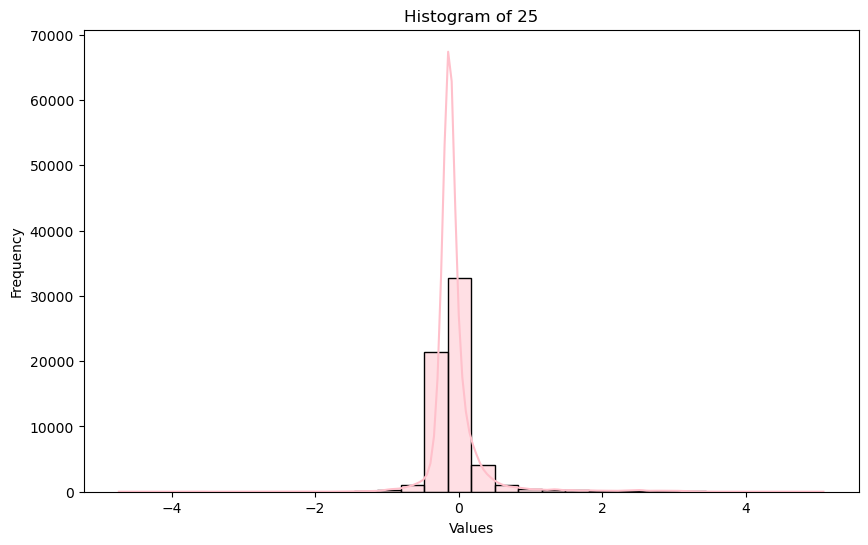

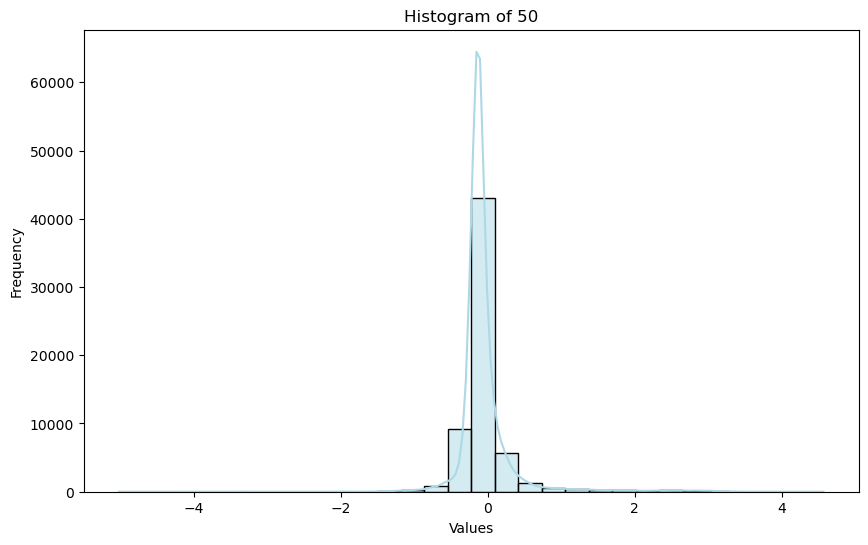

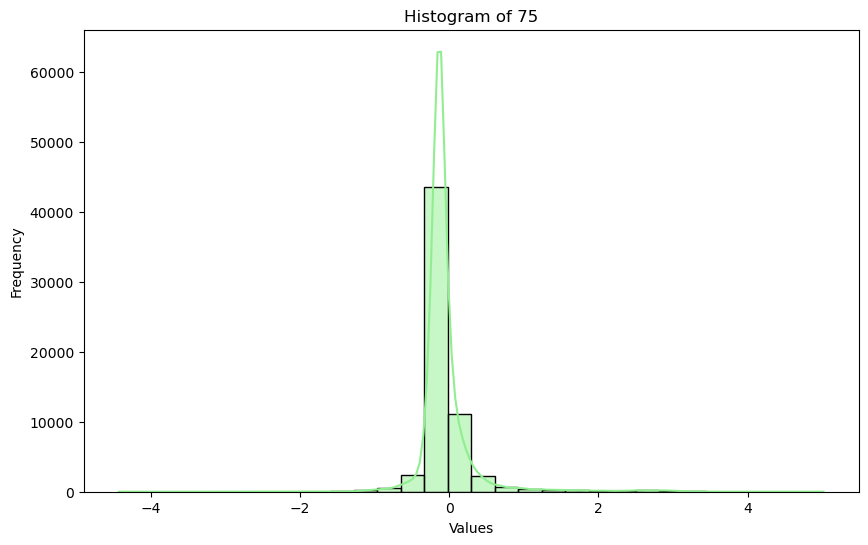

In [21]:
for i,idx in enumerate(sample_columns):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[idx], kde=True, color=colors[i], bins=30)
    plt.title(f"Histogram of {idx}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()


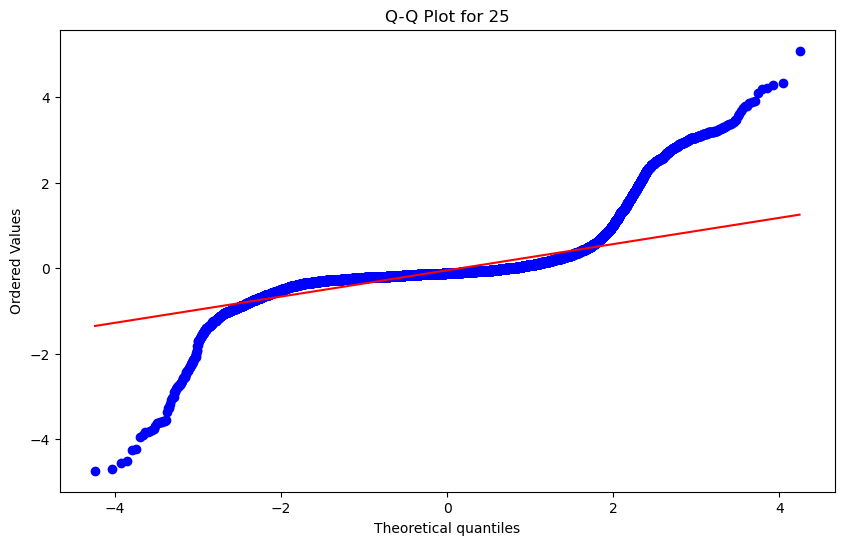

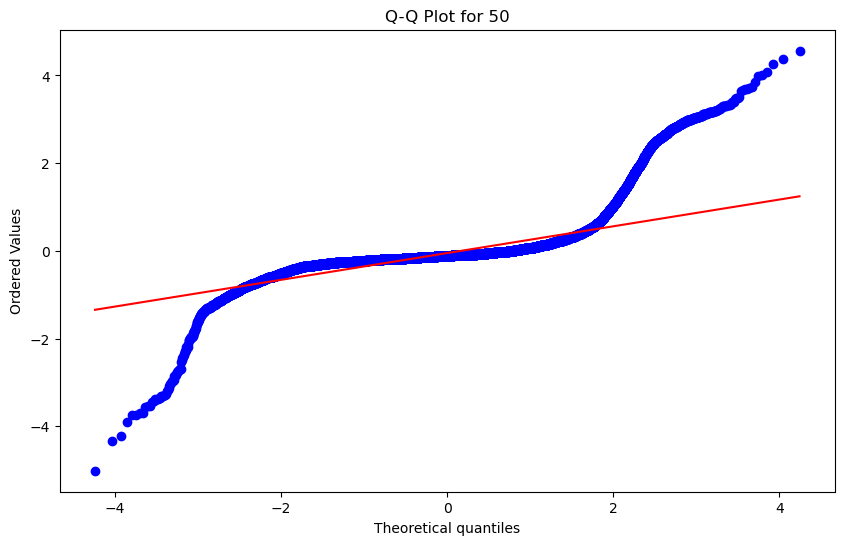

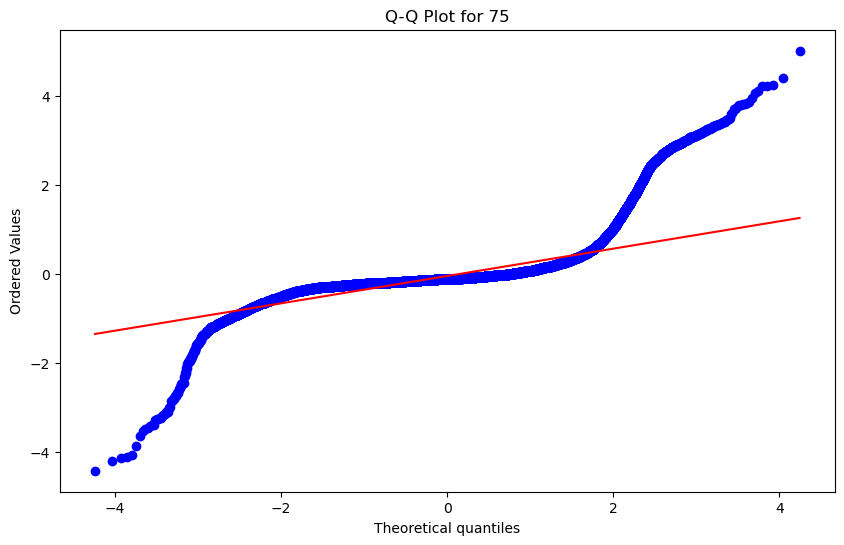

In [22]:
for idx in sample_columns:
    plt.figure(figsize=(10, 6))
    stats.probplot(df[idx], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {idx}")
    plt.show()

Already from here we can see that the three samples are not normally distributed. We can check analytically this using Kolmogorov-Smirnov test.

In [23]:
normal_count = 0
for idx in df.columns:
    mean, std = df[idx].mean(), df[idx].std()
    stat, p_value = kstest(df[idx], 'norm', args=(mean, std))
    if p_value > 0.05:
        normal_count += 1

print(f"Number of normally distributed columns: {normal_count}/{len(df.columns)}")

Number of normally distributed columns: 0/80


None of the columns are normally distributed, which is consistent with the nature of our dataset.

## Autocorrelation

We now take a look at the autocorrelation for three sample time series from our dataset.

Autocorrelation measures how a time series is related to its past values. If there's a strong autocorrelation at certain lags, it means that past values influence future ones — which can be useful for forecasting or understanding patterns in the data.

In the plots below, we use the autocorrelation function to check this. For each time series, we look at up to 20 lags to see how strongly each point is correlated with its previous values.

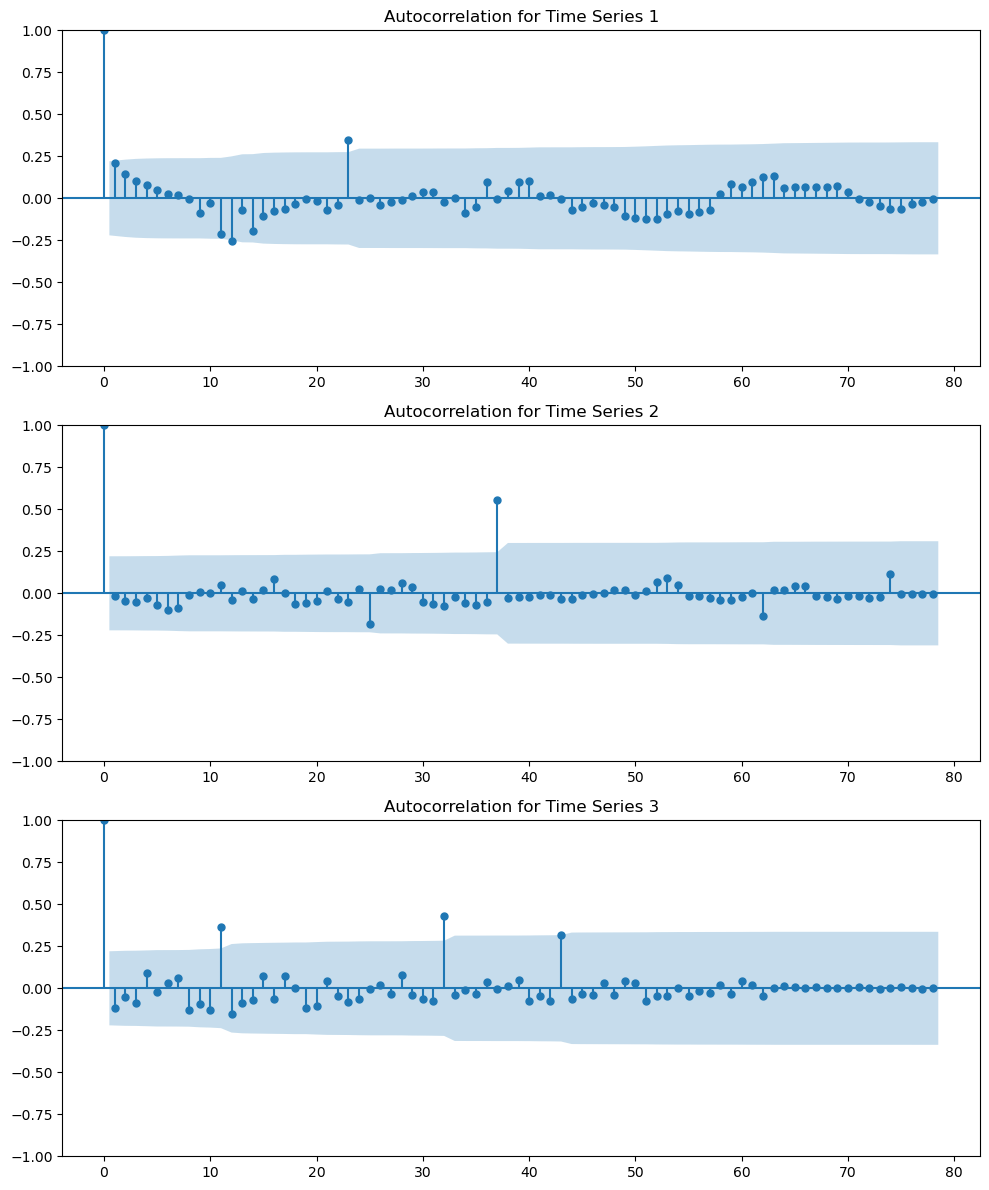

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
selected_series = df.iloc[sample_indices, 1:]

for i, series in enumerate(selected_series.values):
    ax = axes[i]

    plot_acf(series, ax=ax, lags=78)  
    ax.set_title(f'Autocorrelation for Time Series {i + 1}')

plt.tight_layout()
plt.show()


In each plot:

- The **bars** represent the correlation of the time series with its past values (lags).
- The **shaded area** is the confidence interval. If a bar rises above or drops below this shaded region, it means that the correlation at that lag is statistically significant

So, if you see bars outside the shaded area, the time series has a meaningful relationship with its past at those lags. If all bars stay within the shaded area, the time series is likely more random or has very weak autocorrelation.

We can analyze each correlation plot separatelly if we look at it in comparison with the plot of the time series.

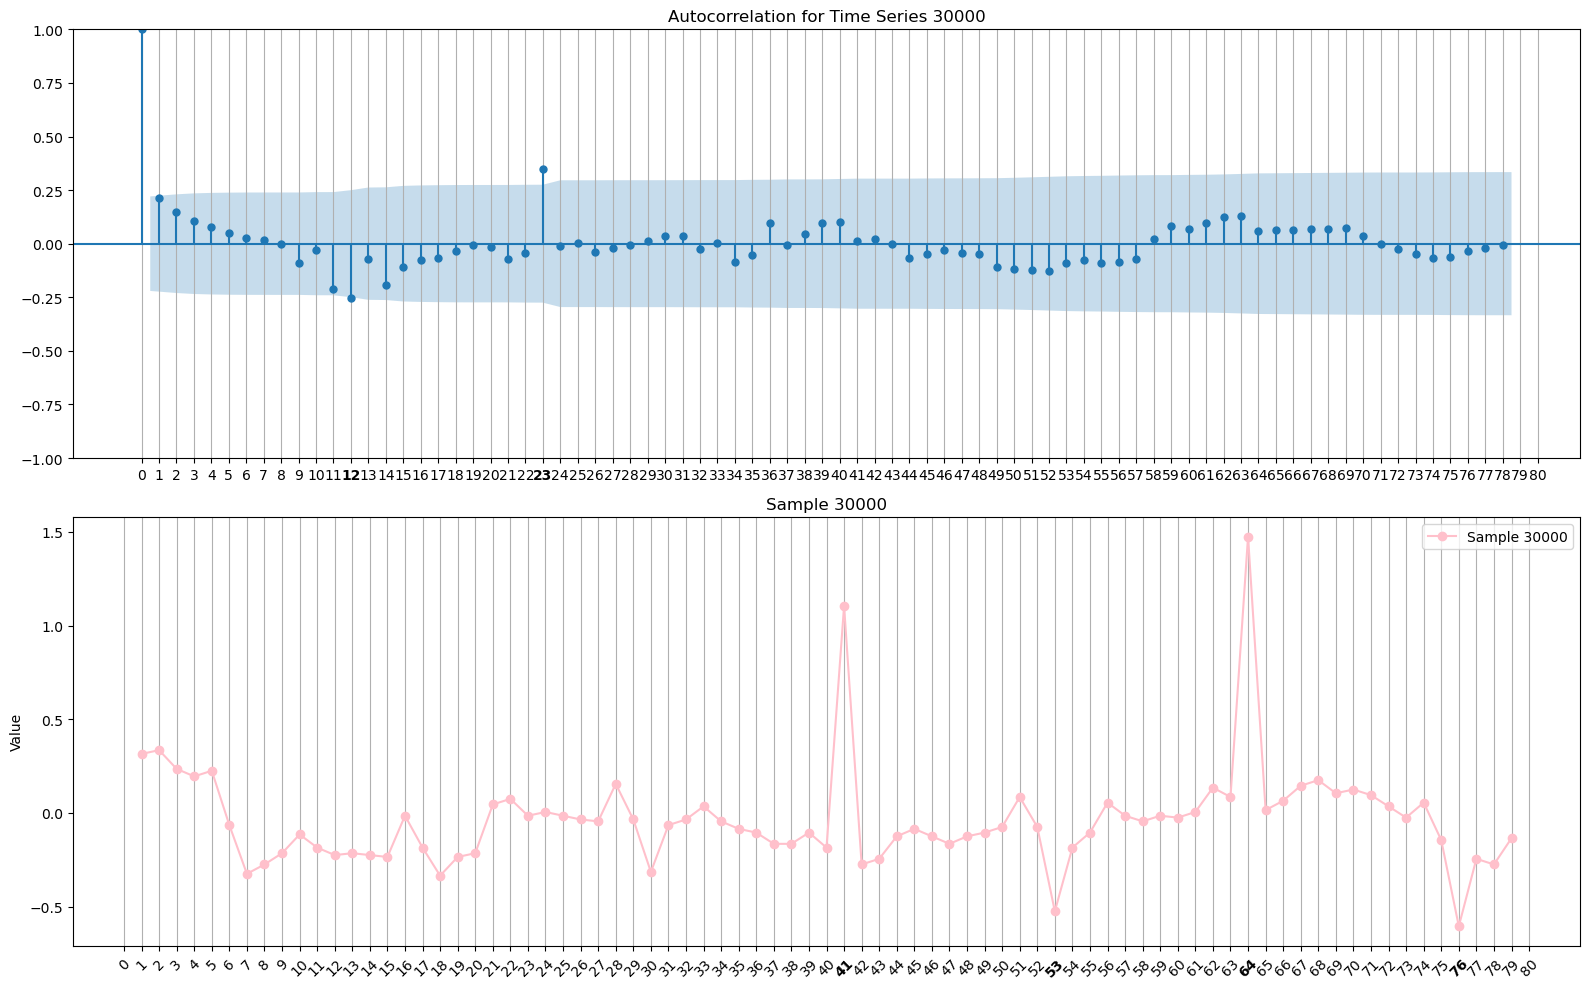

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

plot_acf(df.iloc[sample_indices[0], 1:], ax=axes[0], lags=78)
axes[0].set_title(f'Autocorrelation for Time Series {sample_indices[0]}')
axes[0].set_xticks(range(0, 81, 1))
axes[0].set_xticklabels(range(0, 81, 1))
for tick in axes[0].get_xticklabels():
    if tick.get_text() in ['12', '23']:
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')
plt.xticks(rotation=45)
axes[0].grid(axis='x')

axes[1].plot(df.columns[1:], df.iloc[sample_indices[0], 1:], label=f'Sample {sample_indices[0]}', color=colors[0], marker='o')
axes[1].set_title(f'Sample {sample_indices[0]}')
axes[1].set_ylabel('Value')
axes[1].set_xticks(range(0, 81, 1))
axes[1].set_xticklabels(range(0, 81, 1))
for tick in axes[1].get_xticklabels():
    if tick.get_text() in ['41', '53', '64', '76']:
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')
plt.xticks(rotation=45)
axes[1].grid(axis='x')
axes[1].legend()

plt.tight_layout()
plt.show()

In this first case, looking at the autocorrelation graph, we observe a slightly significant negative correlation at lag 12. Indeed, if we examine the time series plot, starting from the first high peak (x = 41), we can see that the distance to the subsequent low peak (x = 53) is exactly 12. Moving to the next high peak (x = 64), the distance to the following low peak (x = 76) is again 12.

Moreover, the autocorrelation graph shows an even stronger correlation at lag 23. This is consistent with the time series graph, where the distance between the two high peaks and the two low peaks is also 23.

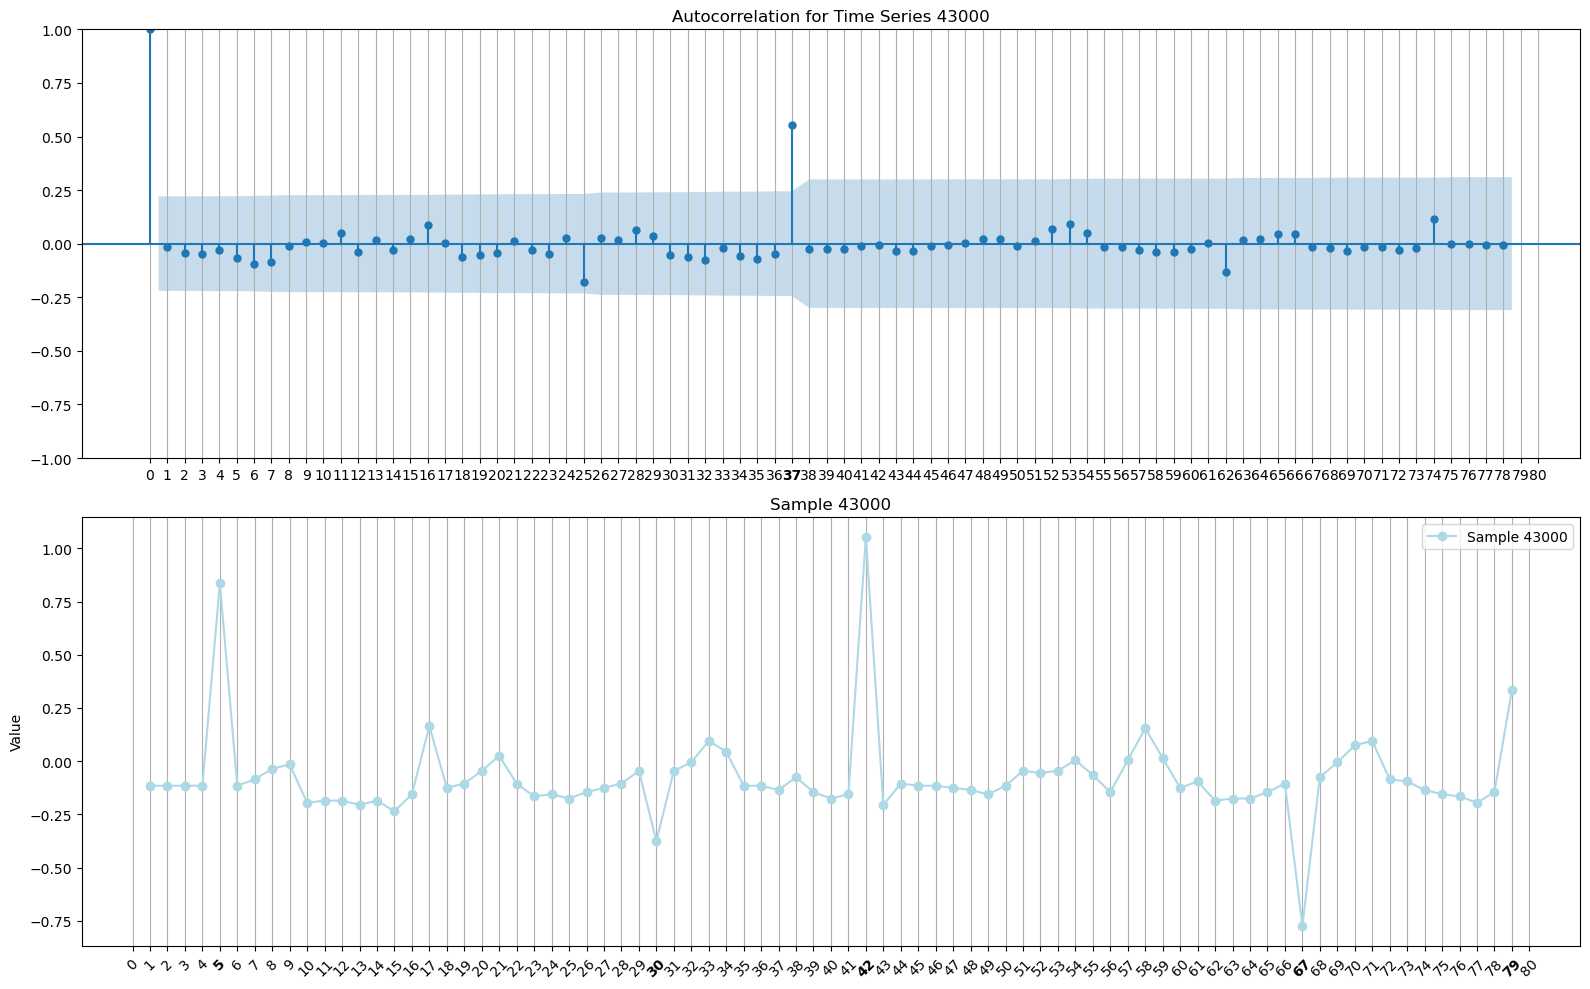

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

plot_acf(df.iloc[sample_indices[1], 1:], ax=axes[0], lags=78)
axes[0].set_title(f'Autocorrelation for Time Series {sample_indices[1]}')
axes[0].set_xticks(range(0, 81, 1))
axes[0].set_xticklabels(range(0, 81, 1))
for tick in axes[0].get_xticklabels():
    if tick.get_text() in ['37']:
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')
plt.xticks(rotation=45)
axes[0].grid(axis='x')

axes[1].plot(df.columns[1:], df.iloc[sample_indices[1], 1:], label=f'Sample {sample_indices[1]}', color=colors[1], marker='o')
axes[1].set_title(f'Sample {sample_indices[1]}')
axes[1].set_ylabel('Value')
axes[1].set_xticks(range(0, 81, 1))
axes[1].set_xticklabels(range(0, 81, 1))
for tick in axes[1].get_xticklabels():
    if tick.get_text() in ['5', '42', '79', '30', '67']:
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')
plt.xticks(rotation=45)
axes[1].grid(axis='x')
axes[1].legend()


plt.tight_layout()
plt.show()

In the second case, we observe a peak in the autocorrelation graph at lag 37. This is supported by the time series plot, where the distance between the high peaks (x = 5, 42, and 79) is consistently 37. Similarly, the distance between the low peaks (x = 30 and 67) is also 37, further confirming the periodic structure reflected in the autocorrelation.

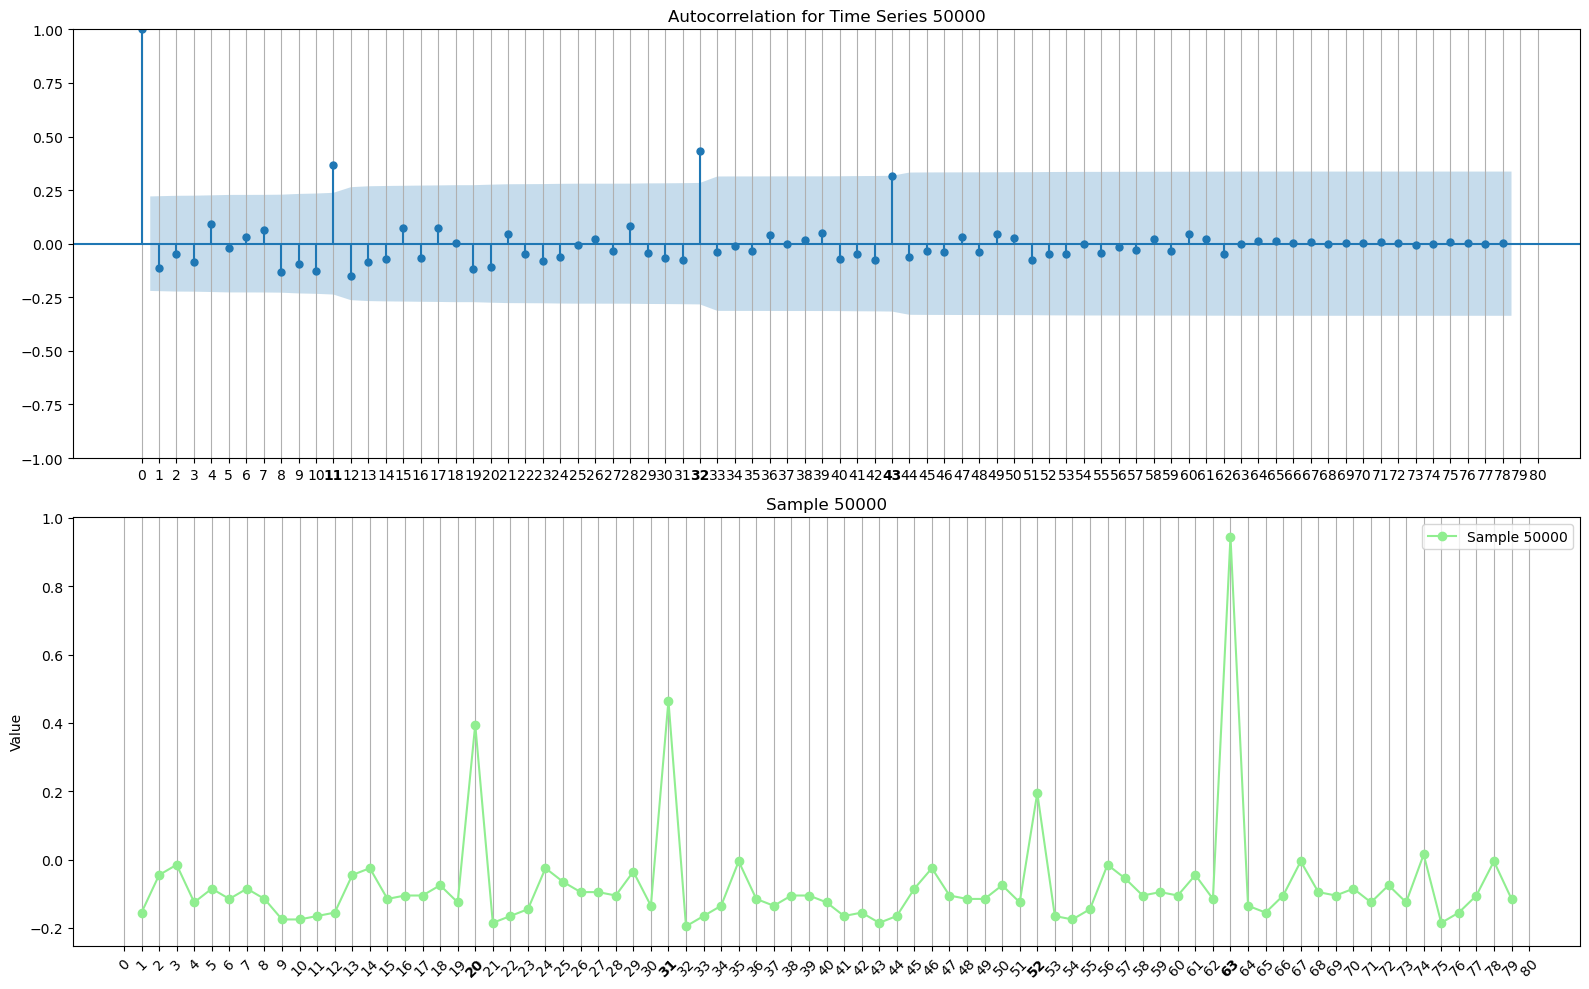

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

plot_acf(df.iloc[sample_indices[2], 1:], ax=axes[0], lags=78)
axes[0].set_title(f'Autocorrelation for Time Series {sample_indices[2]}')
axes[0].set_xticks(range(0, 81, 1))
axes[0].set_xticklabels(range(0, 81, 1))
for tick in axes[0].get_xticklabels():
    if tick.get_text() in ['11', '32', '43']:
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')
plt.xticks(rotation=45)
axes[0].grid(axis='x')

axes[1].plot(df.columns[1:], df.iloc[sample_indices[2], 1:], label=f'Sample {sample_indices[2]}', color=colors[2], marker='o')
axes[1].set_title(f'Sample {sample_indices[2]}')
axes[1].set_ylabel('Value')
axes[1].set_xticks(range(0, 81, 1))
axes[1].set_xticklabels(range(0, 81, 1))
for tick in axes[1].get_xticklabels():
    if tick.get_text() in ['20', '31', '52', '63']:
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')
plt.xticks(rotation=45)
axes[1].grid(axis='x')
axes[1].legend()

plt.tight_layout()
plt.show()

In the third case, we observe an even more peculiar pattern. There are two highly significant correlations at lags 11 and 32 and one slightly significant correlation at lag 43.

The first correlation at lag 11 is illustrated in the time series by a high peak followed by a subsequent higher peak, which occurs between x = 20 and x = 31 and again between x = 52 and x = 63.

The correlation at lag 32 corresponds to the distance between the lower high peaks (x = 20 and x = 52) and the subsequent higher peaks (x = 31 and x = 63).

Finally, the weaker correlation at lag 43 appears to correspond to the distance between the first peak (x = 20) and the last one (x = 63).

The presence of these correlation patterns is closely related to the nature of the dataset. In fact, when measuring heartbeats, we typically observe peaks occurring at regular intervals, depending on the heart rate. This regularity makes the data quite predictable. However, between these peaks, there is noticeable noise that is much harder to predict.

However, the correlations we just analyzed are important because they reveal these underlying patterns in the data, which will be leveraged by the models introduced in the next section for prediction.